## Find regions of interest

This notebooks finds bright spots within 2-d calcium images. The image in question correspons to the Maximum Projection Image (MIP) from a (short) video. The MIP was generated using Fiji

In [1]:
# Import napari - qt magic is aalways needed
%gui qt
import napari

In [2]:
# General imports
import matplotlib.pyplot as plt
from skimage.filters import threshold_local,gaussian
from skimage.io import imread, imshow
from skimage import exposure
from skimage.segmentation import watershed
from skimage.feature import peak_local_max, blob_log
import numpy as np
from scipy import ndimage as ndi
import matplotlib
import matplotlib.pyplot as plt


In [3]:
# Our package imports, need to add parent path
import sys
sys.path.append('..')
from calcium_roi_analysis.params import prepare_paths

## Read input data

### Parameter file
Instead of placing the important parameters in this notebook, they are all saved in a `.yaml` file. This allows better bookiping of different paramters used and makes version control of the code/notebook simpler. When running an experiment, rename the desired parameter file to `current.yaml`

### Read and visulize input image
We load the input image specified in `current.yaml`

In [4]:
params, data_path, output_path = prepare_paths("../parameters/current.yaml")

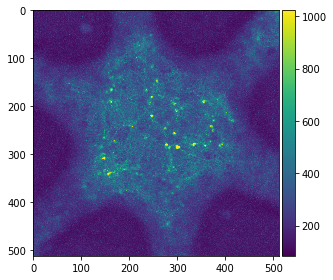

In [7]:
raw = imread(data_path)
imshow(raw)

## Smooth input data

Image processing operations often rely on approximating image derivatives. Smoothing the data helps accuracy. We also look to smooth with a kernel of a sigma that corresponds to the size of the spots we are interested on

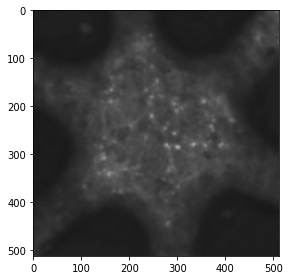

In [8]:
gaussian_image = gaussian(raw*50, sigma = 2.5)
imshow(gaussian_image)

## Adaptive Thresholding
We now threshold based on intensity of local neighborhoolds. We set to back (center) pixels below a specified fraction above the mean (in parameter file)

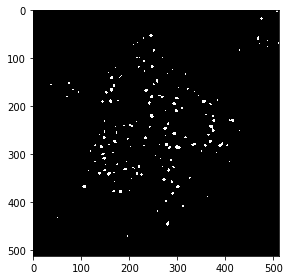

In [9]:
lt = threshold_local(gaussian_image, params['threshold_block_size'], method = 'mean')
binary_lt = gaussian_image > lt + (lt*params['threshold_fraction_above_mean'])
imshow(binary_lt)

## Distance transform
We compute the distance transform using the prior binary image

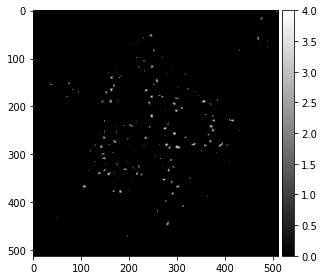

In [16]:
distance = ndi.distance_transform_edt(binary_lt)
imshow(distance, cmap = 'gray')

## Find blobs

We run a laplacian of gaussian piramyd on the distance image to find blobs of different sizes

In [20]:
blobs_log = blob_log(distance, min_sigma=1, max_sigma=5, threshold=params['blobs_log_thresh'], overlap=0.5, exclude_border=1) 

In [19]:
params

{'input_mip': '/Users/mrestrep/projects/borton/calacium_images/example_data/Preprocessedfiles/MAX_6_2_2_24_10x_4minadjust.tif',
 'output_base_path': '/Users/mrestrep/projects/borton/calacium_images/example_data/python_output',
 'threshold_block_size': 5,
 'threshold_fraction_above_mean': 0.02,
 'blobs_log_thresh': 0.03}

## Visualize and curate
We use napari to visualize and interact with image and point layers

The points have different sizes, you can further change the class of a point by changing the threshold on point size using the following key bindings

`y`: increase size for threshold
`t`: decrease size for threshold

You can also select a point - once selected you can toggle the class with `c` 

You can also select and remove points using napari's buitin tools

Once you are satisfied, you can save your data by pressing `f`

In [31]:
# compute unique values of size
blob_sigmas = np.sort(np.unique(blobs_log[:,2]))
blob_sigmas = np.insert(blob_sigmas, 0, 0) 

In [81]:
# create the viewer with an image
current_sigma_idx = 1

properties = {
    'good_point': blobs_log[:,2] > blob_sigmas[current_sigma_idx]
}

 # define the color cycle for the face_color annotation
face_color_cycle = ['red', 'green']

viewer = napari.view_image(distance, rgb=False)

viewer.add_image(gaussian_image, rgb=False)
points_layer = viewer.add_points(blobs_log[:, 0:2],
                                 edge_width=1,
                                 face_color='good_point',
                                 face_color_cycle=face_color_cycle,
                                 name='points',
                                 size=blobs_log[:,2],
                                 properties=properties)

# bind a function to toggle the good_point annotation of the selected points
@viewer.bind_key('y')
def increase_threshold(viewer):
    print("bye")
    global current_sigma_idx
    if current_sigma_idx < len(blob_sigmas):
        current_sigma_idx = current_sigma_idx + 1
    print(f"Filtering with sigma {blob_sigmas[current_sigma_idx]}")
    points_layer.properties['good_point'] = blobs_log[:,2] > blob_sigmas[current_sigma_idx]

    # we need to manually refresh since we did not use the Points.properties setter
    # to avoid changing the color map if all points get toggled to the same class,
    # we set update_colors=False (only re-colors the point using the previously-determined color mapping).
    points_layer.refresh_colors(update_color_mapping=False)

# bind a function to toggle the good_point annotation of the selected points
@viewer.bind_key('t')
def decrease_threshold(viewer):
    print("bye")
    global current_sigma_idx
    if current_sigma_idx > 0:
        current_sigma_idx = current_sigma_idx - 1
    print(f"Filtering with sigma {blob_sigmas[current_sigma_idx]}")
    points_layer.properties['good_point'] = blobs_log[:,2] > blob_sigmas[current_sigma_idx]


    # we need to manually refresh since we did not use the Points.properties setter
    # to avoid changing the color map if all points get toggled to the same class,
    # we set update_colors=False (only re-colors the point using the previously-determined color mapping).
    points_layer.refresh_colors(update_color_mapping=False)

@viewer.bind_key('c')
def toggle_class(viewer):
    selected_points = np.array(list(points_layer.selected_data))
    if len(selected_points) > 0:
        print(f"Toggling {len(selected_points)} points")
        good_point = points_layer.properties['good_point']
        good_point[selected_points] = ~good_point[selected_points]
        points_layer.properties['good_point'] = good_point
        points_layer.refresh_colors(update_color_mapping=False)


@viewer.bind_key('f')
def save_points(viewer):

    print("Saving labeled points to file")
    #save results to files.

    fout = output_path + "/curated_roi.npz"
    np.savez(fout, coords=points_layer.data, isroi=points_layer.properties['good_point'],     size=points_layer.size)

    print("Saved")


## Loading back

In [83]:
fout = output_path + "/curated_roi.npz"
curated_roi = np.load(fout)

In [85]:
sorted(curated_roi.files)

['coords', 'isroi', 'size']

In [89]:
curated_roi['coords']

array([[280.        , 277.        ],
       [256.        , 294.        ],
       [285.        , 300.        ],
       [ 52.        , 245.        ],
       [220.        , 247.        ],
       [190.        , 355.        ],
       [308.        , 147.        ],
       [280.        , 333.        ],
       [281.        , 358.        ],
       [190.        , 162.        ],
       [180.        , 247.        ],
       [165.        , 163.        ],
       [377.        , 182.        ],
       [246.        , 274.        ],
       [241.        , 370.        ],
       [367.        , 107.        ],
       [146.        , 258.        ],
       [444.        , 280.        ],
       [229.        , 415.        ],
       [209.        , 298.        ],
       [117.        , 247.        ],
       [166.        , 235.        ],
       [230.        , 376.        ],
       [341.        , 158.        ],
       [204.        , 309.        ],
       [194.        , 294.        ],
       [284.        , 142.        ],
 